In [8]:
import numpy as np
import astropy.units as u
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

import purepyindi2
from purepyindi2 import IndiClient
client = IndiClient()
client.connect()
client.get_properties()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

v_bias = np.array([[50,50,50]]).T

wavelength = 633e-9
fl = 450e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(pxscl_lamD)


18.389524275269295 arcsec
0.08599262769878883


INFO:purepyindi2.transports:Connected to localhost:7624


In [2]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [6]:
npsf = 100
cam.set_roi(530, 890, npsf, client0)

In [7]:
cam.set_exptime(0.0001, client0)

In [12]:
fsm = ImageStream('fsm')
fsm.write(v_bias)

In [33]:
amp = 0.2*as_per_lamD

freq = 1*u.Hz
t_max = (1/freq).to(u.s)
Nsamps = 10
times = np.linspace(0, t_max, Nsamps)
delt = (times[1]-times[0]).to_value(u.s)

wave = amp*np.sin(2*np.pi*freq.to_value(u.Hz)*times.to_value(u.s))/np.sqrt(2)
volt_commands = np.zeros((Nsamps, 3, 1))
for i in range(Nsamps):
    volt_commands[i] = fsm_utils.get_fsm_volts(tip=wave[i], tilt=0*u.arcsec)
    # volt_commands[i] = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=wave[i])

Displacements: A = 5.00e-06 m, 5.00e-06 m, 5.00e-06 m. 
Delta Voltages: A = 50.00, B = 50.00, C = 50.00. 
Displacements: A = 5.06e-06 m, 4.97e-06 m, 4.97e-06 m. 
Delta Voltages: A = 50.56, B = 49.72, C = 49.72. 
Displacements: A = 5.09e-06 m, 4.96e-06 m, 4.96e-06 m. 
Delta Voltages: A = 50.86, B = 49.57, C = 49.57. 
Displacements: A = 5.08e-06 m, 4.96e-06 m, 4.96e-06 m. 
Delta Voltages: A = 50.76, B = 49.62, C = 49.62. 
Displacements: A = 5.03e-06 m, 4.99e-06 m, 4.99e-06 m. 
Delta Voltages: A = 50.30, B = 49.85, C = 49.85. 
Displacements: A = 4.97e-06 m, 5.01e-06 m, 5.01e-06 m. 
Delta Voltages: A = 49.70, B = 50.15, C = 50.15. 
Displacements: A = 4.92e-06 m, 5.04e-06 m, 5.04e-06 m. 
Delta Voltages: A = 49.24, B = 50.38, C = 50.38. 
Displacements: A = 4.91e-06 m, 5.04e-06 m, 5.04e-06 m. 
Delta Voltages: A = 49.14, B = 50.43, C = 50.43. 
Displacements: A = 4.94e-06 m, 5.03e-06 m, 5.03e-06 m. 
Delta Voltages: A = 49.44, B = 50.28, C = 50.28. 
Displacements: A = 5.00e-06 m, 5.00e-06 m, 5.0

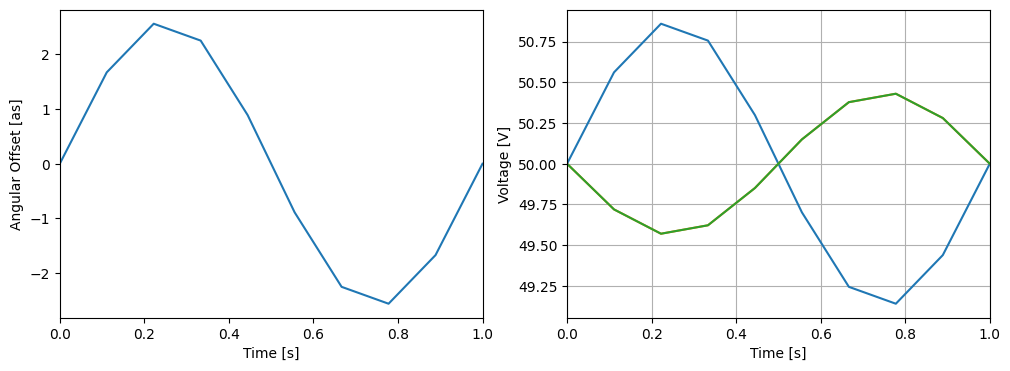

In [34]:

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(times, wave)
plt.xlim([0, t_max.to_value(u.s)])
plt.xlabel('Time [s]')
plt.ylabel('Angular Offset [as]')
# plt.grid()
# plt.show()

plt.subplot(122)
plt.plot(times, volt_commands[:,0])
plt.plot(times, volt_commands[:,1])
plt.plot(times, volt_commands[:,2])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.xlim([0, t_max.to_value(u.s)])
plt.grid()
plt.show()

# plt.subplots_adjust(wspace=10.5)

In [35]:
freq = 3 * Nsamps
try:
    print('Modulating FSM ...')
    i = 0
    start = time.time()
    while i<Nsamps+1:
        if i==Nsamps:
            i = 0
        fsm.write(volt_commands[i])
        time.sleep(1/freq)
        i += 1
except KeyboardInterrupt:
    end = time.time()
    print('FSM modulation stopped!')
    fsm.write(v_bias)
    time.sleep(0.25)
print(start, end)

Modulating FSM ...
FSM modulation stopped!
1732043047.3803666 1732043052.9717803


In [19]:
commands = commands[:,:,0]

In [20]:
commands.shape

(389, 3)

In [21]:
fsm.write(0*v_bias)

In [ ]:
del_freqs = 0.5
fmin = 0.5
fmax = 4
freqs = np.arange(fmin, fmax+del_freqs, del_freqs)
samp_time = 10
Nfs = freqs.shape[0]
Nfs

8

In [ ]:
try:
    print('Modulating FSM ...')
    for j in range(Nfs): 
        freq = freqs[j]
        i = 0
        start = time.time()
        print(f'Started modulation at {freq:.1f}Hz.')
        while i<Nsamps+1 and time.time()<(start+samp_time):
            if i==Nsamps:
                i = 0
            fsm.write(volt_commands[i])
            time.sleep(1/freq)
            i += 1
except KeyboardInterrupt:
    print('FSM modulation stopped!')
    fsm.write(0*v_bias)
    time.sleep(1)
    fsm.write(v_bias)
    time.sleep(0.25)

Modulating FSM ...
Started modulation at 0.5Hz.
Started modulation at 1.0Hz.
Started modulation at 1.5Hz.
Started modulation at 2.0Hz.
FSM modulation stopped!


In [92]:
fsm.write(0*v_bias)

In [93]:
fsm.close()